# Выбор локации для скважины <a id="title"></a>

**Цель исследования**:

1. Построить модель для предсказания объёма запасов в новых скважинах
2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины
3. Посчитать риски и прибыль для каждого региона
4. Предложить регион для разработки скважин

**Ход исследования**:

Основные данные получаем из файлов: ```geo_data_0.csv```, ```geo_data_1.csv```, ```geo_data_2.csv```. Они содержит данные данные геологоразведки трёх регионов.
Структура данных во всех трех файлах одинакова:
+ ```id``` — уникальный идентификатор скважины;
+ ```f0```, ```f1```, ```f2``` — три признака точек;
+ ```product``` — объём запасов в скважине (тыс. баррелей), целевой признак.

Мы проверим данные на наличие пропусков и дубликатов, проверим соответствие типов данных. 

Затем обучим модель линейной регрессии для предсказания объема запасов в скважинах для каждого региона.

После чего подготовимся к расчёту прибыли: рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

Затем напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Проанализируем результаты и предложим регион для разработки скважин.

Таким образом, исследование пройдет в 7 этапов:
1. Загрузка данных
2. Предобработка данных:  
    + проверка имен столбцов
    + проверка наличия пропусков
    + проверка типов данных
    + проверка наличия дубликатов
3. Анализ данных:
    + проверка наличия выбросов и аномалий
    + проверка мультиколлинеарности
4. Обучение моделей линейной регрессии:
    + подготовка датасетов
    + обучение моделей
    + сравнение моделей
5. Подготовка к расчету прибыли:
    + сохранение ключевых значений для расчетов в отдельные константы
    + расчет достаточного объема сырья для безубыточной разработки
6. Расчет прибыли и рисков:
    + написание функции для расчета прибыли по выбранным скважинам и предсказаниям модели
    + применение техники bootstrap для нахождения распределения прибыли
    + вычисление средней прибыли, 95%-го доверительного интервала и риска убытков.
    + выбор лучшего региона для разработки
7. Общий вывод

## Загрузка и подготовка данных

### Импорт библиотек и объявление констант

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler

from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

### Вспомогательные функции

In [3]:
def describe_df(df, n=5):
    """Описывает датафрейм df.
    Выводит первые n строк датафрейма,
    общую информацию о датафрейме,
    количество пропусков и полных дубликатов.
    """
    print(f'Первые {n} строк датафрейма:')
    display(df.head(n))
    print('_' * 40, '\n')
    print('Общая информация о датайрейме:')
    df.info()
    print('_' * 40, '\n')
    print('Количество пропусков:')
    frame = ({'Количество пропусков' : df.isna().sum().sort_values(ascending=False), 
          'Доля пропусков, %' : round((df.isna().mean()*100), 2).sort_values(ascending=False)})
    display(pd.DataFrame(frame).sort_values(by='Доля пропусков, %', ascending=False))
    print('_' * 40, '\n')
    print(f'Количество явных дубликатов: {df.duplicated().sum()}')

In [4]:
def describe_df_advanced(df):
    """Описывает датафрейм df.
    Выводит описательные статистики, строит гистограммы и матрицу корреляций.
    """
    display(df.describe())
    interval_cols = df.select_dtypes(include='number').columns.tolist()
    
    fig, axes = plt.subplots(nrows=1, ncols=len(interval_cols), figsize=(6*len(interval_cols),6))
    for idx,col in enumerate(interval_cols):
        df[col].hist(ax=axes[idx], bins='sturges')
        axes[idx].set_title('Распределение ' + col)
        
    phik_overview = phik_matrix(df, interval_cols=interval_cols)
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$',
        figsize=(7, 5)
    )

### Загрузка данных

In [6]:
data0 = pd.read_csv('./datasets/geo_data_0.csv')
data1 = pd.read_csv('./datasets/geo_data_1.csv')
data2 = pd.read_csv('./datasets/geo_data_2.csv')

Посмотрим на датафрейм с данными о регионе 0.

In [7]:
describe_df(data0)

Первые 5 строк датафрейма:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


________________________________________ 

Общая информация о датайрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
________________________________________ 

Количество пропусков:


,Количество пропусков,"Доля пропусков, %"
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


________________________________________ 

Количество явных дубликатов: 0


В датафрейме 5 столбцов и 100000 строк. 4 столбца содержат вещественные значения: ```f0```, ```f1```, ```f2```, ```product``` и один - строковые ```id```. Дубликатов и пропусков нет.

Посмотрим на датафрейм с информацией о регионе 1.

In [8]:
describe_df(data1)

Первые 5 строк датафрейма:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


________________________________________ 

Общая информация о датайрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
________________________________________ 

Количество пропусков:


,Количество пропусков,"Доля пропусков, %"
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


________________________________________ 

Количество явных дубликатов: 0


В датафрейме 5 столбцов и 100000 строк. 4 столбца содержат вещественные значения: ```f0```, ```f1```, ```f2```, ```product``` и один - строковые ```id```. Дубликатов и пропусков нет.

Посмотрим на датафрейм с информацией о регионе 2.

In [9]:
describe_df(data2)

Первые 5 строк датафрейма:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


________________________________________ 

Общая информация о датайрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
________________________________________ 

Количество пропусков:


,Количество пропусков,"Доля пропусков, %"
id,0,0.0
f0,0,0.0
f1,0,0.0
f2,0,0.0
product,0,0.0


________________________________________ 

Количество явных дубликатов: 0


В датафрейме 5 столбцов и 100000 строк. 4 столбца содержат вещественные значения: ```f0```, ```f1```, ```f2```, ```product``` и один - строковые ```id```.
Дубликатов и пропусков нет.

Все три датафрейма содержат 100000 строк, без дубликатов и пропусков. Типы данных в датафреймах соответствуют заявленным.

### Анализ данных

Удалим из датафреймов столбец с id, т.к. для обучения он нам не понадобится.

In [10]:
for df in [data0, data1, data2]:
    df.drop('id', axis=1, inplace=True)

Посмотрим подробнее на значения данных в столбцах.

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


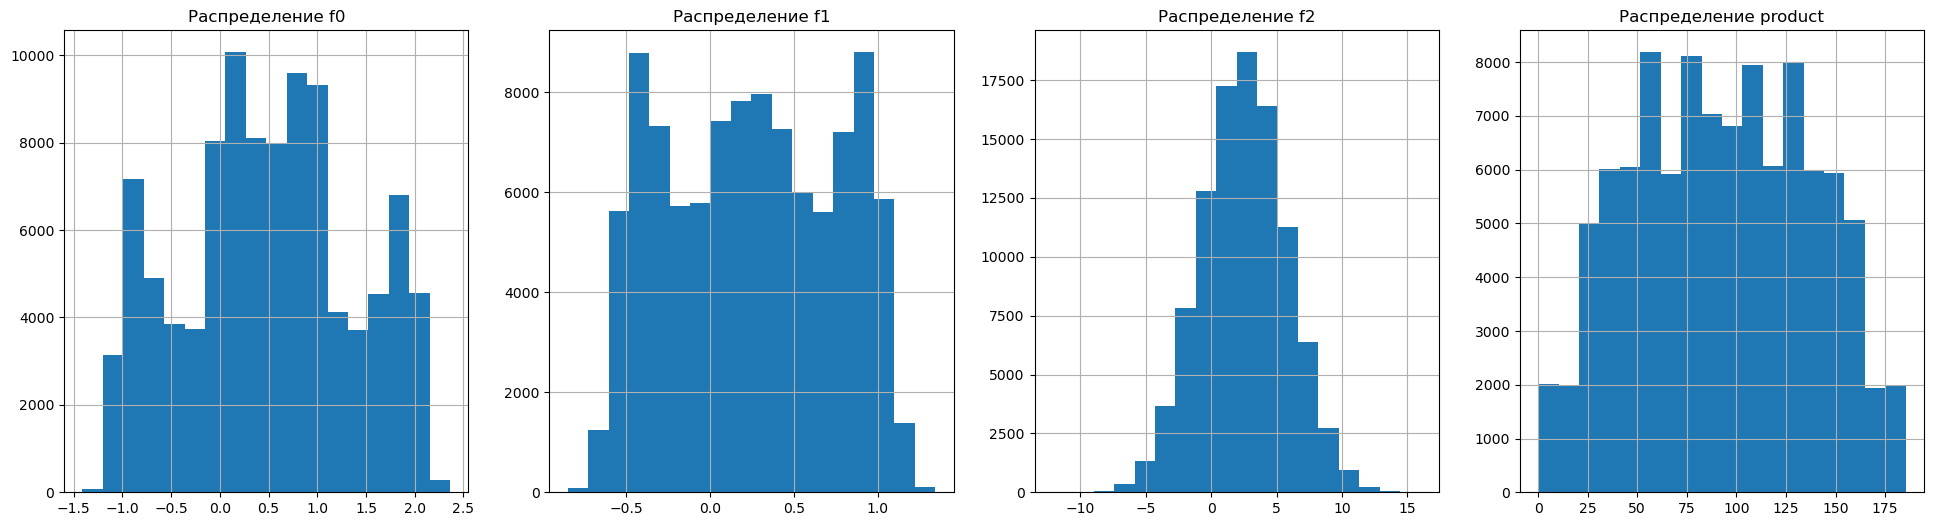

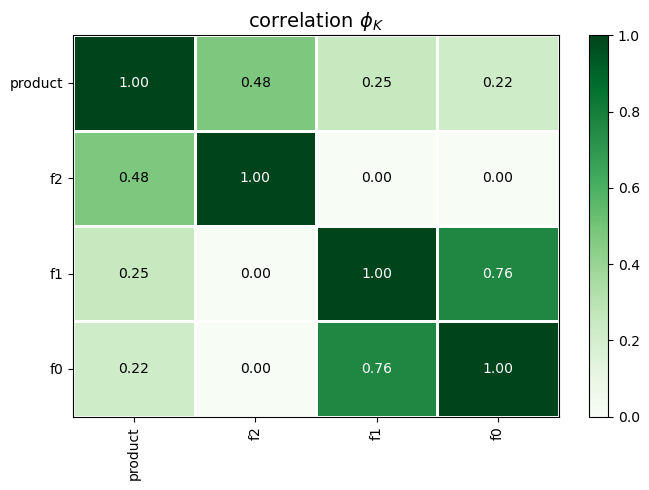

In [11]:
describe_df_advanced(data0)

Входные признаки вещественные, выбросов не обнаружено. Диапазон значений признака ```f2``` заметно отличается от двух других, поэтому перед обучением отмасштабируем признаки.

Мультиколлинеарность входных признаков не наблюдается.

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


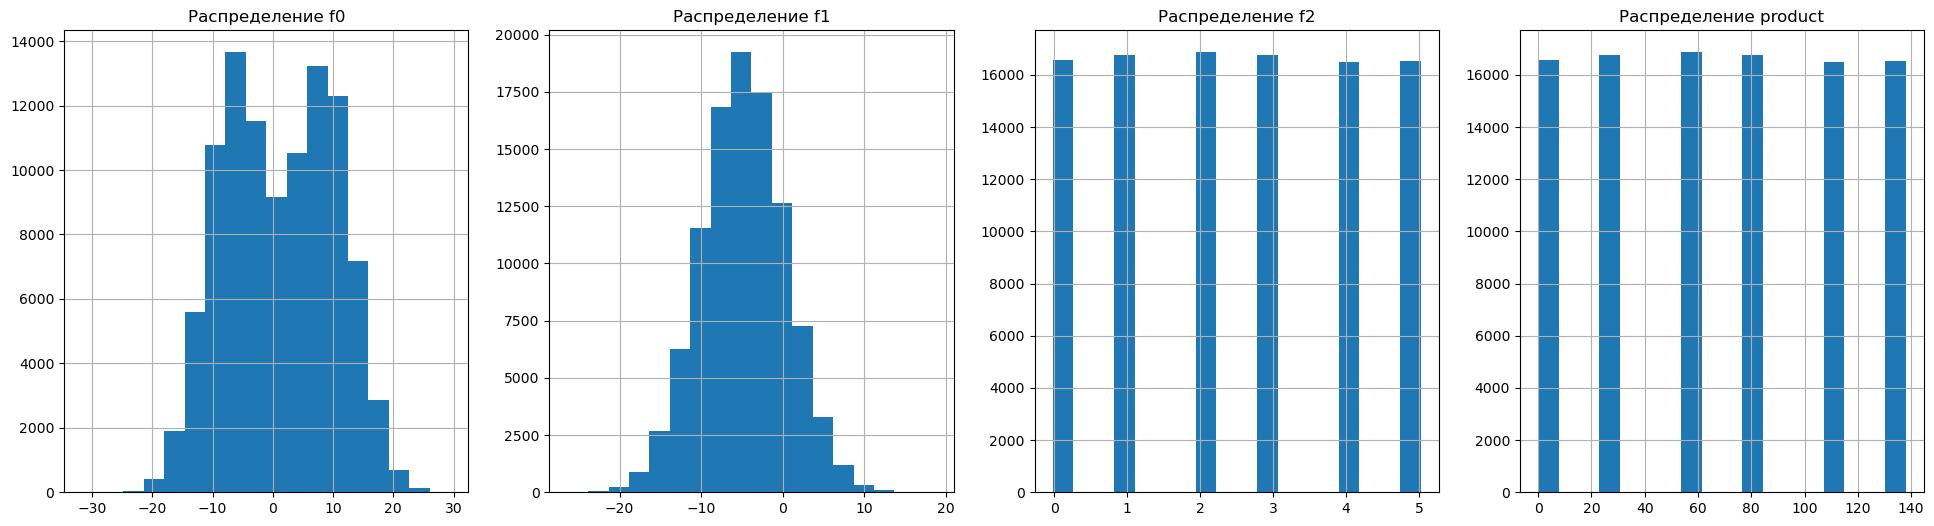

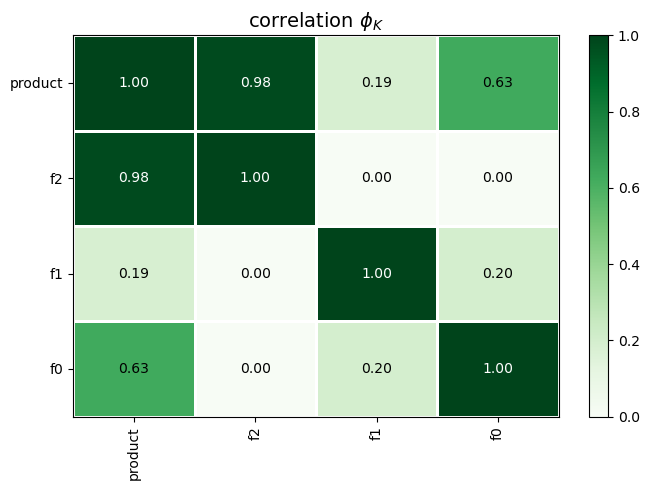

In [12]:
describe_df_advanced(data1)

Входные признаки вещественные, диапазон значений признака ```f2``` заметно отличается от двух других, поэтому перед обучением отмасштабируем признаки.

Мультиколлинеарность входных признаков не наблюдается. Наблюдается очень сильная связь целевого признака с признаком ```f2``` (коэффициент 0.98).

In [13]:
data1['f2'].value_counts()

f2
-0.005876    1
 4.007133    1
 3.002704    1
 1.995378    1
 1.004327    1
            ..
 3.009891    1
 2.000013    1
 0.017600    1
 4.007500    1
-0.003299    1
Name: count, Length: 100000, dtype: int64

По гистограмме признак ```f2``` похож на дискретный, но на самом деле все значения уникальны, просто они скапливаются вокруг 6 целочисленных значений.

In [14]:
data1['product'].value_counts()

product
53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: count, dtype: int64

А вот целевой признак принимает всего несколько значений, каждого из которых в таблице примерно одинаковое количество.

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


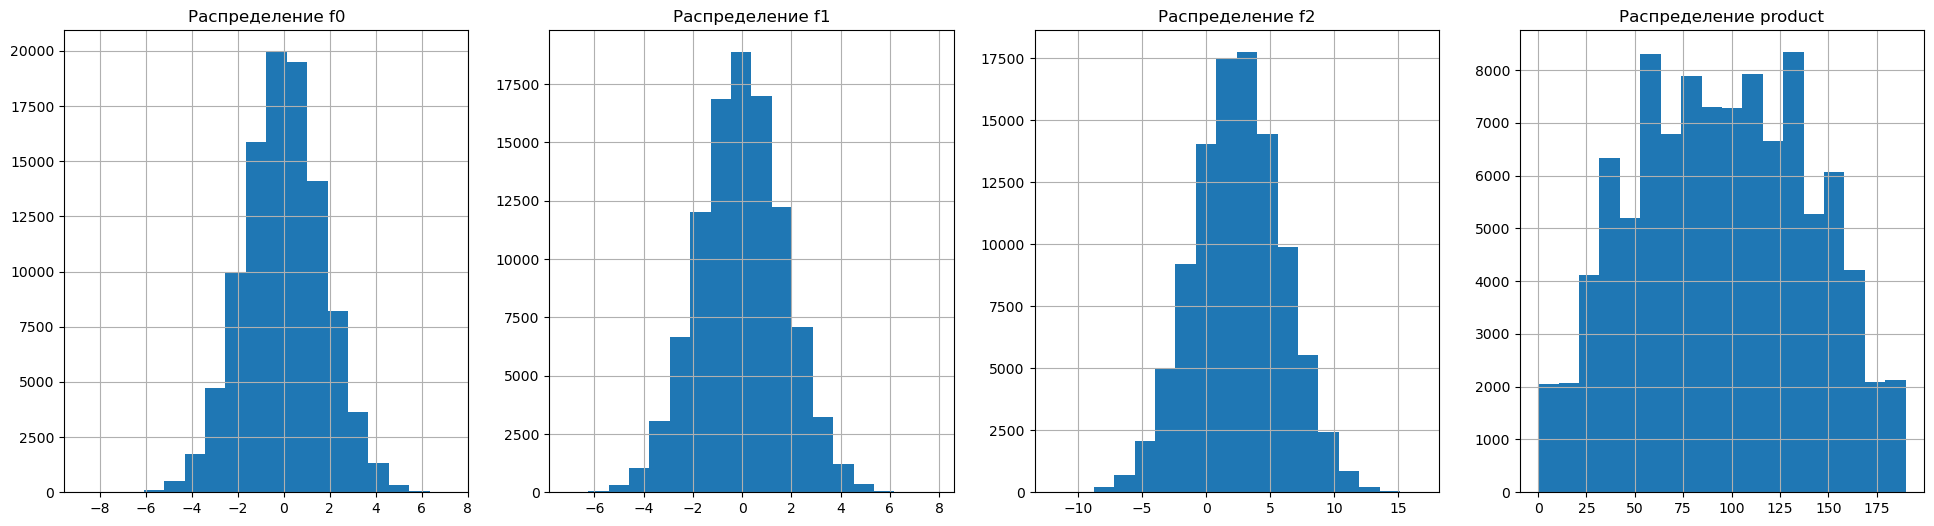

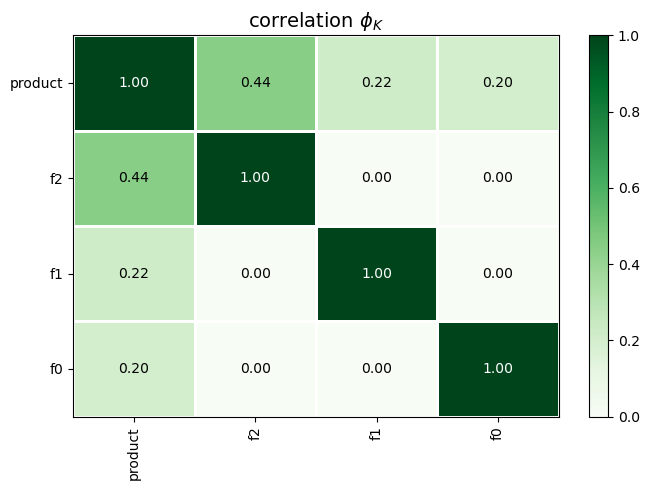

In [15]:
describe_df_advanced(data2)

Входные признаки вещественные, выбросов не обнаружено. диапазон значений признака ```f2``` заметно отличается от двух других, поэтому перед обучением отмасштабируем признаки.

Мультиколлинеарность входных признаков не наблюдается.

### Загрузка и подготовка данных - итог

1. Загрузили данные о скважинах в трех регионах.
2. Каждый датафрейм содержит 5 столбцов и 100000 строк. 4 столбца содержат вещественные значения: ```f0```, ```f1```, ```f2```, ```product``` и один - строковые ```id```. Проверили данные на соответствие требованиям - все заявленные столбцы присутствуют, типы соответствуют описанным в требованиях. Пропусков и дубликатов не обнаружено.
3. Столбец ```id``` удалили, т.к. для обучения он не требуется.
4. Вещественные входные признаки будем масштабировать.
5. Проверили данные на мультиколлинеарность - мультиколлинеарность входных признаков не наблюдается.

## Обучение и проверка модели

### Вспомогательные функции

In [16]:
def prepare_dataset(df, target, test_size=0.25):
    """ Подготавливает выборки из датафрейма df.
    Выделяет целевой признак target.
    Разбивает данные на train/valid с test_size=test_size.
    Масштабирует количественные признаки.
    Возвращает X_train, X_valid, y_train, y_valid.
    """
    y = df[target]
    X = df.drop(target, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE, 
        test_size=test_size
    )
    
    num_col_names = X_train.select_dtypes(include='number').columns.tolist()
    scaler = StandardScaler()
    X_train[num_col_names] = scaler.fit_transform(X_train[num_col_names])
    X_valid[num_col_names] = scaler.transform(X_valid[num_col_names])
    
    return X_train, X_valid, y_train, y_valid

In [17]:
def check_shape(data, X_train, X_valid, y_train, y_valid):
    """ Проверяет размерности выборок, полученных разбиением
    данных из датафрейма data на train и valid.
    Возвращает True, если с размерностями всё ОК, и False, если не ОК.
    """
    print(f'Исходные данные: {data.shape},\n\tX_train: {X_train.shape}, X_valid: {X_valid.shape}\
    \n\ty_train: {y_train.shape}, y_valid: {y_valid.shape}')
    print(f'Всего строк: {data.shape[0]}, Строк Train + Valid: {X_train.shape[0] + X_valid.shape[0]}')
    if data.shape[0] == X_train.shape[0] + X_valid.shape[0]:
        print('Общее количество строк совпадает')
    else:
        print('Количество строк в Train + valid не совпадает с исходным')
        return False
    print(f'Строк Train: {X_train.shape[0]} (X), {y_train.shape[0]} (y)')
    if X_train.shape[0] == y_train.shape[0]:
        print('Количество строк во входных признаках и целевом в Train совпадает')
    else:
        print('Количество строк во входных признаках и целевом в Train не совпадает')
        return False
    print(f'Строк Valid: {X_valid.shape[0]} (X), {y_valid.shape[0]} (y)')
    if X_valid.shape[0] == y_valid.shape[0]:
        print('Количество строк во входных признаках и целевом в Valid совпадает')
    else:
        print('Количество строк во входных признаках и целевом в Valid не совпадает')
        return False
    return True

### Разбиение данных

Произведем разбиение данных на обучающую и валидационную выборки (в соотношении 75:25), используя написанную нами вспомогательную функцию. Функция также произведет масштабирование признаков.


In [18]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = prepare_dataset(data0, 'product', TEST_SIZE)

In [19]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = prepare_dataset(data1, 'product', TEST_SIZE)

In [20]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = prepare_dataset(data2, 'product', TEST_SIZE)

Проверим размерности получившихся выборок.


In [21]:
check_shape(data0, X_train_0, X_valid_0, y_train_0, y_valid_0)

Исходные данные: (100000, 4),
	X_train: (75000, 3), X_valid: (25000, 3)    
	y_train: (75000,), y_valid: (25000,)
Всего строк: 100000, Строк Train + Valid: 100000
Общее количество строк совпадает
Строк Train: 75000 (X), 75000 (y)
Количество строк во входных признаках и целевом в Train совпадает
Строк Valid: 25000 (X), 25000 (y)
Количество строк во входных признаках и целевом в Valid совпадает


True

In [22]:
check_shape(data1, X_train_1, X_valid_1, y_train_1, y_valid_1)

Исходные данные: (100000, 4),
	X_train: (75000, 3), X_valid: (25000, 3)    
	y_train: (75000,), y_valid: (25000,)
Всего строк: 100000, Строк Train + Valid: 100000
Общее количество строк совпадает
Строк Train: 75000 (X), 75000 (y)
Количество строк во входных признаках и целевом в Train совпадает
Строк Valid: 25000 (X), 25000 (y)
Количество строк во входных признаках и целевом в Valid совпадает


True

In [23]:
check_shape(data2, X_train_2, X_valid_2, y_train_2, y_valid_2)

Исходные данные: (100000, 4),
	X_train: (75000, 3), X_valid: (25000, 3)    
	y_train: (75000,), y_valid: (25000,)
Всего строк: 100000, Строк Train + Valid: 100000
Общее количество строк совпадает
Строк Train: 75000 (X), 75000 (y)
Количество строк во входных признаках и целевом в Train совпадает
Строк Valid: 25000 (X), 25000 (y)
Количество строк во входных признаках и целевом в Valid совпадает


True

С размерностями всё ОК.

### Обучение моделей

Обучим модели линейной регрессии на данных по каждому региону.

Обучим модель для нулевого региона.

In [24]:
lr0 = LinearRegression()
lr0.fit(X_train_0, y_train_0)

LinearRegression()

Сохраним предсказанные объемы запасов сырья, средний объем запасов сырья и RMSE на валидационной выборке.


In [25]:
y_pred_0 = lr0.predict(X_valid_0)
rmse0 = mean_squared_error(y_valid_0, y_pred_0, squared=False)
mean0 = y_pred_0.mean()

Обучим модель для первого региона.

In [26]:
lr1 = LinearRegression()
lr1.fit(X_train_1, y_train_1)

LinearRegression()

Сохраним предсказания и RMSE для первого региона.

In [27]:
y_pred_1 = lr1.predict(X_valid_1)
rmse1 = mean_squared_error(y_valid_1, y_pred_1, squared=False)
mean1 = y_pred_1.mean()

Обучим модель для второго региона.

In [28]:
lr2 = LinearRegression()
lr2.fit(X_train_2, y_train_2)

LinearRegression()

Сохраним предсказания и RMSE для второго региона.

In [29]:
y_pred_2 = lr2.predict(X_valid_2)
rmse2 = mean_squared_error(y_valid_2, y_pred_2, squared=False)
mean2 = y_pred_2.mean()

Сравним модели.

In [30]:
mean_col = [mean0, mean1, mean2]
rmse_col = [rmse0, rmse1, rmse2]

In [31]:
lr_metrics = {'mean': mean_col, 'RMSE': rmse_col}
lr_metrics_table = pd.DataFrame(lr_metrics, index=[0, 1, 2])
lr_metrics_table.index.name = 'Регион'

In [32]:
(lr_metrics_table
 .style
 .format({'mean': '{:.2f}', 'RMSE': '{:.2f}'})
 .highlight_max(subset='mean', color='lightgreen')
 .highlight_min(subset='RMSE', color='lightgreen')
 .relabel_index(['Средний запас,</br>тыс. баррелей', 'RMSE'], axis=1)
)

,"Средний запас,тыс. баррелей",RMSE
Регион,,
0,92.40,37.76
1,68.71,0.89
2,94.77,40.15


Наибольший средний предсказанный запас сырья во втором регионе. Но модель для второго региона показывает худшие результаты: у нее самый большой RMSE - 40.15, близкий к нему RMSE и у модели для нулевого региона - 37.76.

Наименьший RMSE у модели для первого региона - 0.89, что значительно меньше, чем у двух других моделей. Вероятно, хорошее качество модели для первого региона связано с тем, что у целевого признака в первом регионе очень большая корреляция с одним из входных признаков.

### Обучение и проверка моделей - итог

Обучили и проверили модели линейной регрессии для каждого региона.

1. Разбили данные на обучающую и валидационную выборки в соотношении 75:25.
2. Обучили модель и сделали предсказания на валидационной выборке.
3. Сохранили предсказания и правильные ответы на валидационной выборке.
4. Сравнили средний запас предсказанного сырья и RMSE моделей:
<table>
<tr>
    <th>Регион</th>
    <th>Средний запас,<br>тыс. баррелей</th> 
    <th>RMSE</th> 
</tr>
<tr>
    <th>0</th>
    <th>92.40</th> 
    <th>37.76</th> 
</tr>
<tr>
    <th>1</th>
    <th>68.71</th> 
    <th>0.89</th> 
</tr>
<tr>
    <th>2</th>
    <th>94.77</th> 
    <th>40.15</th> 
</tr>
</table>
Таким образом, лучшее качество показывает модель для региона 1. В этом же регионе наблюдалась крайне высокая (0.98) корреляция целевого признака со входным.

## Подготовка к расчёту прибыли

### Объявление констант

Все ключевые значения для расчётов сохраним в отдельных константах.
+ Бюджет на разработку скважин в регионе — 10 млрд рублей.
+ Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
+ При разведке региона исследуют 500 точек
+ Из которых с помощью машинного обучения выбирают 200 лучших для разработки.

In [34]:
REGION_BUDGET = 10 ** 10
PROFIT_PER_ITEM = 450_000
N_SELECTED = 500
N_BEST = 200

### Расчет достаточного объёма сырья для безубыточной разработки

Рассчитаем достаточный объем сырья для безубыточной разработки. Для безубыточной разработки суммарная выручка с разрабатываемых скважин должна быть не меньше бюджета, затраченного на их разработку. Значит, для получения значения достаточного объема сырья нам нужно разделить бюджет (```REGION_BUDGET```) на количество скважин (```N_BEST```), помноженное на доход с единицы продукта (```PROFIT_PER_ITEM```).

In [35]:
profitable_volume = REGION_BUDGET / (N_BEST * PROFIT_PER_ITEM)

In [36]:
profitable_volume

111.11111111111111

Таким образом, минимальный объем сырья, получаемый каждой скважиной, должен быть 111.1 тыс. баррелей, чтобы разработка была безубыточной.

Сравним полученное значение со средними значениями предсказанного объема сырья для каждого региона.

In [37]:
for idx, mean_vol in enumerate(mean_col):
    print(f'Средний предсказанный объем сырья в регионе {idx} - {mean_vol:.2f} баррелей.')
    if mean_vol < profitable_volume:
        print(f'Предсказанный объем сырья меньше достаточного \
объема ({profitable_volume:.2f}) для безубыточной разработки')
    else:
        print(f'Предсказанный объем сырья достаточен для безубыточной разработки')
    print('_'*25)

Средний предсказанный объем сырья в регионе 0 - 92.40 баррелей.
Предсказанный объем сырья меньше достаточного объема (111.11) для безубыточной разработки
_________________________
Средний предсказанный объем сырья в регионе 1 - 68.71 баррелей.
Предсказанный объем сырья меньше достаточного объема (111.11) для безубыточной разработки
_________________________
Средний предсказанный объем сырья в регионе 2 - 94.77 баррелей.
Предсказанный объем сырья меньше достаточного объема (111.11) для безубыточной разработки
_________________________


Таким образом, ни в одном регионе предсказанный средний объем сырья не достаточен для безубыточной разработки.

### Подготовка к расчету прибыли - итог

Произвели подготовку к расчету прибыли.
1. Все ключевые значения для расчётов сохранили в отдельных константах.
2. Рассчитали достаточный объём сырья для безубыточной разработки новой скважины. Достаточный объем сырья в одной скважине для безубыточной разработки - 111.1 тыс. баррелей.
3. Сравнили полученный объём сырья со средним запасом в каждом регионе. Ни в одном регионе предсказанный средний объем сырья не достаточен для безубыточной разработки.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли.

In [38]:
def profit(target, pred, count):
    """ Подсчитывает прибыль с count скважин,
    используя предсказания объемов сырья probabilities
    и целевое значение target.
    Возвращает сумму прибыли.
    """
    pred_sorted = pred.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return PROFIT_PER_ITEM * selected.sum() - REGION_BUDGET

Напишем функцию, находящую распределение прибыли, используя bootstrap.

In [39]:
def profit_bootstrap(target, pred, n):
    """ Проводит процедуру bootstrap с n выборок.
    Возвращает среднюю прибыль, 95%-й доверительный интервал и риск убытков.
    """
    target.reset_index(drop=True, inplace=True)
    pred.reset_index(drop=True, inplace=True)
    state = np.random.RandomState(RANDOM_STATE)
    values = []
    for i in range(n):
        target_subsample = target.sample(n=N_SELECTED, random_state=state, replace=True)
        pred_subsample = pred[target_subsample.index] 
        values.append(profit(target_subsample, pred_subsample, N_BEST))
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean()
    return mean, (lower,  upper), risk

Рассчитаем прибыль и риски для трех регионов. Используем bootstrap с 1000 выборок.

In [40]:
mean0, interval0, risk0 = profit_bootstrap(pd.Series(y_valid_0), pd.Series(y_pred_0), 1000)

In [41]:
mean1, interval1, risk1 = profit_bootstrap(pd.Series(y_valid_1), pd.Series(y_pred_1), 1000)

In [42]:
mean2, interval2, risk2 = profit_bootstrap(pd.Series(y_valid_2), pd.Series(y_pred_2), 1000)

Выведем таблицу со сравнением расчетов по регионам.

In [43]:
mean_col = [mean0, mean1, mean2]
lower_col = [interval0[0], interval1[0], interval2[0]]
upper_col = [interval0[1], interval1[1], interval2[1]]
risk_col = [risk0, risk1, risk2]

In [44]:
bootstrap_result = {'mean': mean_col, 'lower': lower_col, 'upper': upper_col, 'risk': risk_col}
bootstrap_result_table = pd.DataFrame(bootstrap_result, index=[0, 1, 2])
bootstrap_result_table.index.name = 'Регион'

In [45]:
bootstrap_result_table['mean_mil'] = bootstrap_result_table['mean'] / 1000000
bootstrap_result_table['interval_mil'] = \
    round(bootstrap_result_table['lower'] / 1000000, 2).astype('string') + ' - ' \
    + round(bootstrap_result_table['upper'] / 1000000, 2).astype('string')
bootstrap_result_table = bootstrap_result_table[['mean_mil', 'interval_mil', 'risk']]

In [46]:
(bootstrap_result_table
 .style
 .format({'mean_mil': '{:.2f}', 'risk': '{:.2%}'})
 .highlight_max(subset='mean_mil', color='lightgreen')
 .apply(lambda row: ['background: lightgreen'] if (row['risk'] < 0.025) else [''], axis=1, subset=['risk'])
 .relabel_index(['Средняя прибыль,</br>млн руб.', '95% доверительный интервал,</br>млн руб.', 'Риск убытков'], axis=1)
)

,"Средняя прибыль,млн руб.","95% доверительный интервал,млн руб.",Риск убытков
Регион,,,
0,427.85,-97.25 - 954.22,5.50%
1,511.36,98.87 - 940.72,0.90%
2,402.58,-137.16 - 929.89,7.40%


Единственный регион с выполняемым условием "вероятность убытков меньше 2.5%" - регион 1. Вероятность убытков в этом регионе - меньше процента (0.9%), в то время как в двух других она значительно превышает 2.5%. Регион 1 также имеет наибольшую среднюю прибыль в регионе - 511 млн. рублей.

Таким образом, для разработки скважин предлагается брать **регион №1**.

## Общий вывод

Проанализировали данные о нефтяных скважинах в трех регионах, спрогнозировали объёмы запасов в новых скважинах и составили рекомендации по выбору региона для разработки.

1. Провели предобработку данных: проверили данные на наличие пропущенных значений и дубликатов, проверили типы данных и имена столбцов.
2. Провели анализ данных: каждый датафрейм содержит 5 столбцов и 100000 строк. 4 столбца содержат вещественные значения: f0, f1, f2, product и один - строковые id. Столбец id удалили, т.к. для обучения он не требуется. Вещественные входные признаки будем масштабировать. Также проверили данные на мультиколлинеарность - мультиколлинеарность входных признаков не наблюдается.
3. Обучили и проверили модели линейной регрессии для каждого региона.
    + Разбили данные на обучающую и валидационную выборки в соотношении 75:25.
    + Обучили модель и сделали предсказания на валидационной выборке.
    + Сохранили предсказания и правильные ответы на валидационной выборке.
    + Сравнили средний запас предсказанного сырья и RMSE моделей:
<table>
<tr>
    <th>Регион</th>
    <th>Средний запас,<br>тыс. баррелей</th> 
    <th>RMSE</th> 
</tr>
<tr>
    <th>0</th>
    <th>92.40</th> 
    <th>37.76</th> 
</tr>
<tr>
    <th>1</th>
    <th>68.71</th> 
    <th>0.89</th> 
</tr>
<tr>
    <th>2</th>
    <th>94.77</th> 
    <th>40.15</th> 
</tr>
</table>
Таким образом, лучшее качество показывает модель для региона 1. В этом же регионе наблюдалась крайне высокая (0.98) корреляция целевого признака со входным.
4. Подготовились к расчету прибыли.
    + Все ключевые значения для расчётов сохранили в отдельных константах.
    + Рассчитали достаточный объём сырья для безубыточной разработки новой скважины. Достаточный объем сырья в одной скважине для безубыточной разработки - 111.1 тыс. баррелей.
    + Сравнили полученный объём сырья со средним запасом в каждом регионе. Ни в одном регионе предсказанный средний объем сырья не достаточен для безубыточной разработки.
5. Используя технику bootstrap на 1000 выборок нашли распределение прибыли в каждом регионе. Подсчитали среднюю прибыль, 95%-й доверительный интервал и риск убытков:
<table>
<tr>
    <th>Регион</th>
    <th>Средняя прибыль,<br>млн. руб.</th> 
    <th>95% доверительный интервал,<br>млн руб.</th>
    <th>Риск убытков</th>
</tr>
<tr>
    <th>0</th>		
    <th>427.85</th> 
    <th>-97.25 - 954.22</th> 
    <th>5.50%</th> 
</tr>
<tr>
    <th>1</th>
    <th>511.36</th> 
    <th>98.87 - 940.72</th> 
    <th>0.90%</th> 
</tr>
<tr>
    <th>2</th>
    <th>402.58</th> 
    <th>-137.16 - 929.89</th> 
    <th>7.40%</th> 
</tr>
</table>

Единственный регион с выполняемым условием "вероятность убытков меньше 2.5%" - регион 1. Вероятность убытков в этом регионе - меньше процента (0.9%), в то время как в двух других она значительно превышает 2.5%. Регион 1 также имеет наибольшую среднюю прибыль в регионе - 511 млн. рублей.

Таким образом, для разработки скважин предлагается брать **регион №1** - он единственный из трех имеет вероятность убытков менее 2.5%. Кроме того, в нем наибольшая средняя прибыль - 511 млн. рублей. Также модель регрессии для первого региона показала наилучшее качество (наименьшую среднеквадратичную ошибку).

[В начало](#title)